<a href="https://colab.research.google.com/github/jimmyAUT/HR_Data_analysis/blob/main/HR_data_analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Currently, there is a high rate of turnover among Salifort employees. (Note: In this context, turnover data includes both employees who choose to quit their job and employees who are let go). Salifort strives to create a corporate culture that supports employee success and professional development. Further, the high turnover rate is costly in the financial sense. Salifort makes a big investment in recruiting, training, and upskilling its employees.

If Salifort could predict whether an employee will leave the company, and discover the reasons behind their departure, they could better understand the problem and develop a solution.

As a first step, the leadership team asks Human Resources to survey a sample of employees to learn more about what might be driving turnover.  

* Task:
To analyze the survey data and come up with ideas for how to increase employee retention. Design a model that predicts whether an employee will leave the company based on their job title, department, number of projects, average monthly hours, and any other relevant data points. A good model will help the company increase retention and job satisfaction for current employees, and save money and time training new employees.

In [4]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [5]:
# For data manipulation
import numpy as np
import pandas as pd

# For data visualization
import matplotlib.pyplot as plt
import seaborn as sns

# Display all columns of the table
pd.set_option('display.max_columns',None)

# For data modeling
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.ensemble import RandomForestClassifier

from xgboost import XGBClassifier, XGBRegressor, plot_importance

# For performance metrics
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score,\
roc_auc_score, roc_curve, confusion_matrix, ConfusionMatrixDisplay, classification_report

import pickle


# Plan:Initial EDA and data cleaning

In [6]:
df = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/HR data analysis/HR_comma_sep.csv')
df.head()

,satisfaction_level,last_evaluation,number_project,average_montly_hours,time_spend_company,Work_accident,left,promotion_last_5years,Department,salary
0,0.38,0.53,2,157,3,0,1,0,sales,low
1,0.80,0.86,5,262,6,0,1,0,sales,medium
2,0.11,0.88,7,272,4,0,1,0,sales,medium
3,0.72,0.87,5,223,5,0,1,0,sales,low
4,0.37,0.52,2,159,3,0,1,0,sales,low


In [7]:
# Check missing value
print(df.isna().sum())
df.info()

satisfaction_level       0
last_evaluation          0
number_project           0
average_montly_hours     0
time_spend_company       0
Work_accident            0
left                     0
promotion_last_5years    0
Department               0
salary                   0
dtype: int64
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14999 entries, 0 to 14998
Data columns (total 10 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   satisfaction_level     14999 non-null  float64
 1   last_evaluation        14999 non-null  float64
 2   number_project         14999 non-null  int64  
 3   average_montly_hours   14999 non-null  int64  
 4   time_spend_company     14999 non-null  int64  
 5   Work_accident          14999 non-null  int64  
 6   left                   14999 non-null  int64  
 7   promotion_last_5years  14999 non-null  int64  
 8   Department             14999 non-null  object 
 9   salary                 14999 no

In [8]:
# Rename columns' name to make they all in snake_case and lower case
df = df.rename(columns={'time_spend_company':'tenure','average_montly_hours':'average_monthly_hours'})
df.columns = df.columns.str.lower()
df.columns

Index(['satisfaction_level', 'last_evaluation', 'number_project',
       'average_monthly_hours', 'tenure', 'work_accident', 'left',
       'promotion_last_5years', 'department', 'salary'],
      dtype='object')

In [9]:
# Check duplication
print(df.duplicated().value_counts())

# Remove duplication
df1 = df.drop_duplicates(keep='first')


False    11991
True      3008
Name: count, dtype: int64


In [10]:
# Check descriptive statistic
df1.describe()

,satisfaction_level,last_evaluation,number_project,average_monthly_hours,tenure,work_accident,left,promotion_last_5years
count,11991.000000,11991.000000,11991.000000,11991.000000,11991.000000,11991.000000,11991.000000,11991.000000
mean,0.629658,0.716683,3.802852,200.473522,3.364857,0.154282,0.166041,0.016929
std,0.241070,0.168343,1.163238,48.727813,1.330240,0.361234,0.372133,0.129012
min,0.090000,0.360000,2.000000,96.000000,2.000000,0.000000,0.000000,0.000000
25%,0.480000,0.570000,3.000000,157.000000,3.000000,0.000000,0.000000,0.000000
50%,0.660000,0.720000,4.000000,200.000000,3.000000,0.000000,0.000000,0.000000
75%,0.820000,0.860000,5.000000,243.000000,4.000000,0.000000,0.000000,0.000000
max,1.000000,1.000000,7.000000,310.000000,10.000000,1.000000,1.000000,1.000000


The maximum value of tenure is twice of quantile 75%, indicated there might be outliers.

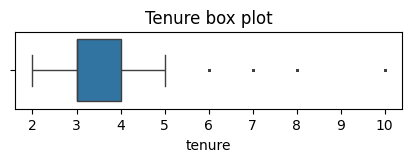

In [11]:
# Check box plot of tenure
plt.figure(figsize=(5,1))
sns.boxplot(data=df1,x='tenure',fliersize=0.5)
plt.title('Tenure box plot')
plt.show()

In [12]:
# Define outliers boundary
# Interquartile Range iqr=q3-q1
q1 = df['tenure'].quantile(0.25)
q3 = df['tenure'].quantile(0.75)
iqr = q3-q1

upper_limit = q3 + 1.5 * iqr
lower_limit = q1 - 1.5 * iqr

print('Upper limit', upper_limit, ', Lower limit', lower_limit)

# Identify number of outliers
df1['tenure'][(df1['tenure'] > upper_limit) | (df1['tenure'] < lower_limit)].count()

Upper limit 5.5 , Lower limit 1.5


824

# Analyze: Further EDA
What are the relationships between variables?

What are the distributions in the data?

What transformations did you make with your data? Why did you chose to make those decisions?

What are some purposes of EDA before constructing a predictive model?


In [13]:
# Check the number of employee who left vs. stay
print(df1['left'].value_counts())
print(df1['left'].value_counts(normalize=True))

left
0    10000
1     1991
Name: count, dtype: int64
left
0    0.833959
1    0.166041
Name: proportion, dtype: float64


It is an imbalanced data, but not very extreme.

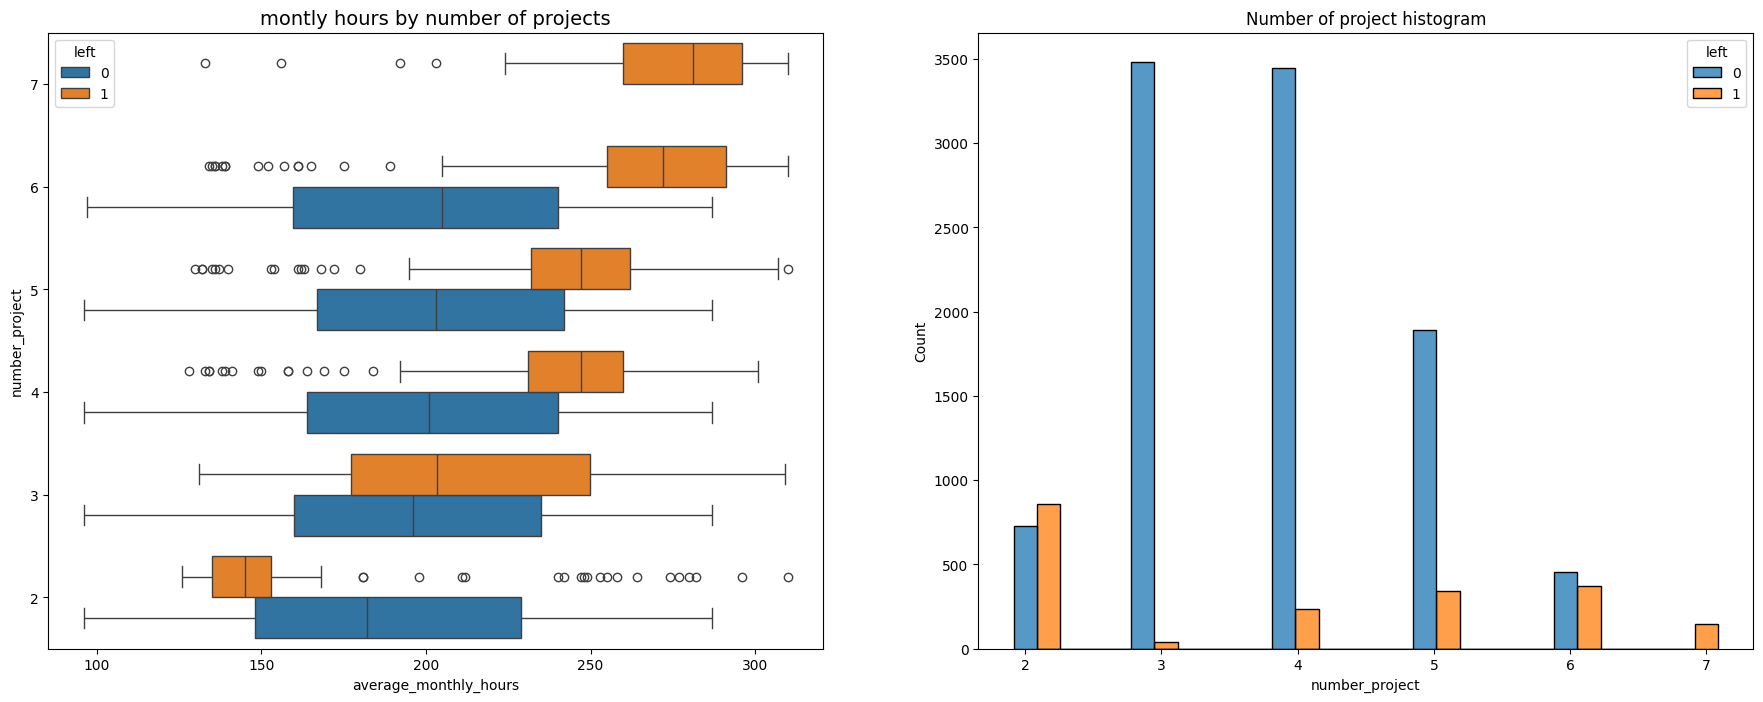

In [14]:
# Compare number_project and average_monthly_hours

fig, ax = plt.subplots(1, 2, figsize=(22,8))

sns.boxplot(data=df1, x='average_monthly_hours', y='number_project', hue='left',
            orient='h', ax=ax[0])
ax[0].invert_yaxis()
ax[0].set_title("montly hours by number of projects", fontsize=14)

# Check the left vs. stay distribution with number_project
sns.histplot(data=df1, x='number_project', hue='left', multiple='dodge', shrink=2, ax=ax[1])
ax[1].set_title('Number of project histogram')

plt.show()

Employee who work on more projects would also work longer hours. With the mean hours of each group (stayed and left) increasing with number of projects worked.

However, there are two groups of employees who left the company: (A) those who worked considerably less than their peers with the same number of projects, and (B) those who worked much more.

Of those in group A, it's possible that they were fired. It's also possible that this group includes employees who had already given their notice and were assigned fewer hours because they were already on their way out the door. For those in group B, it's reasonable to infer that they probably quit. The people in group B likely contributed a lot to the projects they worked in; they might have been the largest contributors to their projects.

Everyone with seven projects left the company, and the interquartile ranges of this group and those who left with six projects was ~255–295 hours/month—much more than any other group.

The optimal number of projects for employees to work on seems to be 3–4. The ratio of left/stayed is very small for these cohorts.

Assume a work week of 40 hours and two weeks of vacation per year, then the average number of working hours per month of employees working Monday–Friday = 50 weeks * 40 hours per week / 12 months = 166.67 hours per month. This means that, aside from the employees who worked on two projects, every group—even those who didn't leave the company—worked considerably more hours than this. It seems that employees here are overworked.

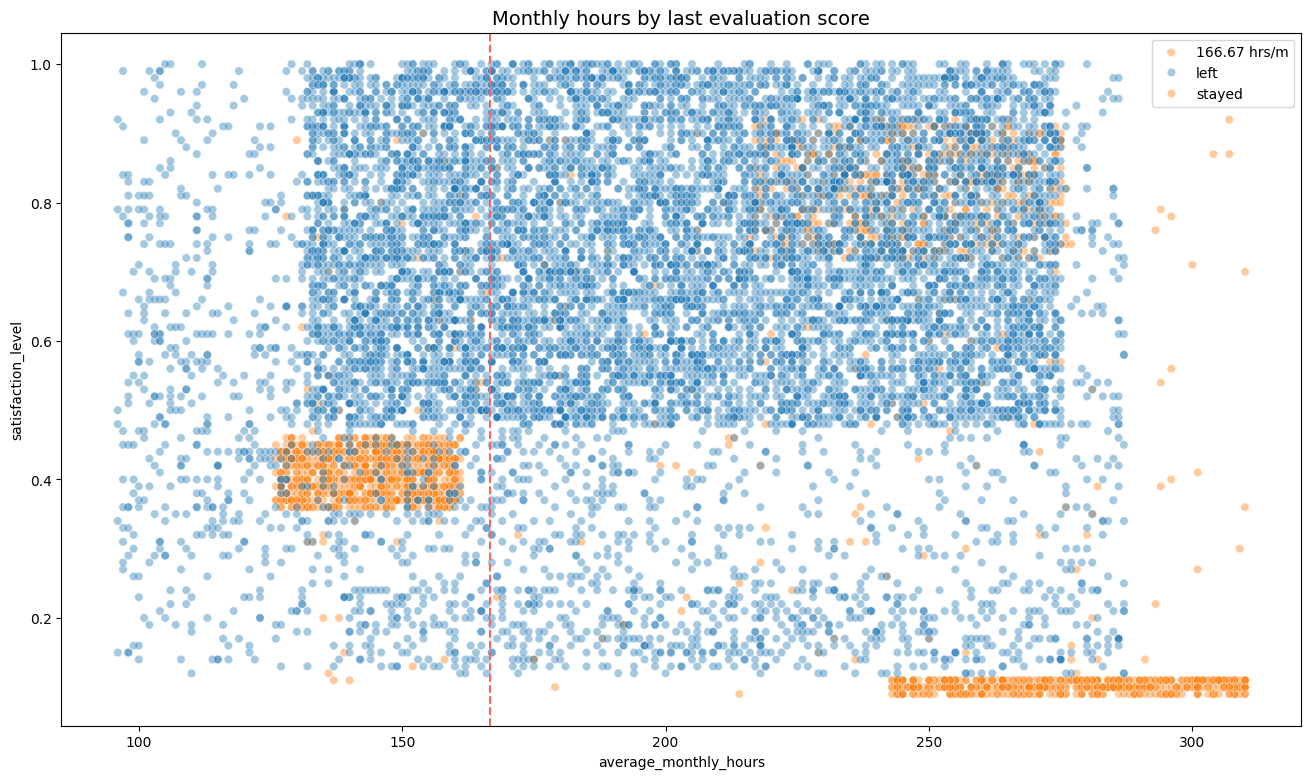

In [15]:
# Check the average monthly hours versus the satisfaction levels.
plt.figure(figsize=(16,9))
sns.scatterplot(data=df1,x='average_monthly_hours',y='satisfaction_level', hue='left', alpha=0.4)
plt.axvline(x=166.67, color='#ff6361', label='166.67 hrs/m', ls='--')
plt.legend(labels=['166.67 hrs/m', 'left', 'stayed'])
plt.title('Monthly hours by last evaluation score', fontsize='14');

The scatterplot above shows that there was a sizeable group of employees who worked ~240–315 hours per month. 315 hours per month is over 75 hours per week for a whole year. It's likely this is related to their satisfaction levels being close to zero.

The plot also shows another group of people who left, those who had more normal working hours. Even so, their satisfaction was only around 0.4. It's difficult to speculate about why they might have left. It's possible they felt pressured to work more, considering so many of their peers worked more. And that pressure could have lowered their satisfaction levels.

Finally, there is a group who worked ~210–280 hours per month, and they had satisfaction levels ranging ~0.7–0.9.

The shape of the distributions here indicate there might be data manipulation or synthetic data.


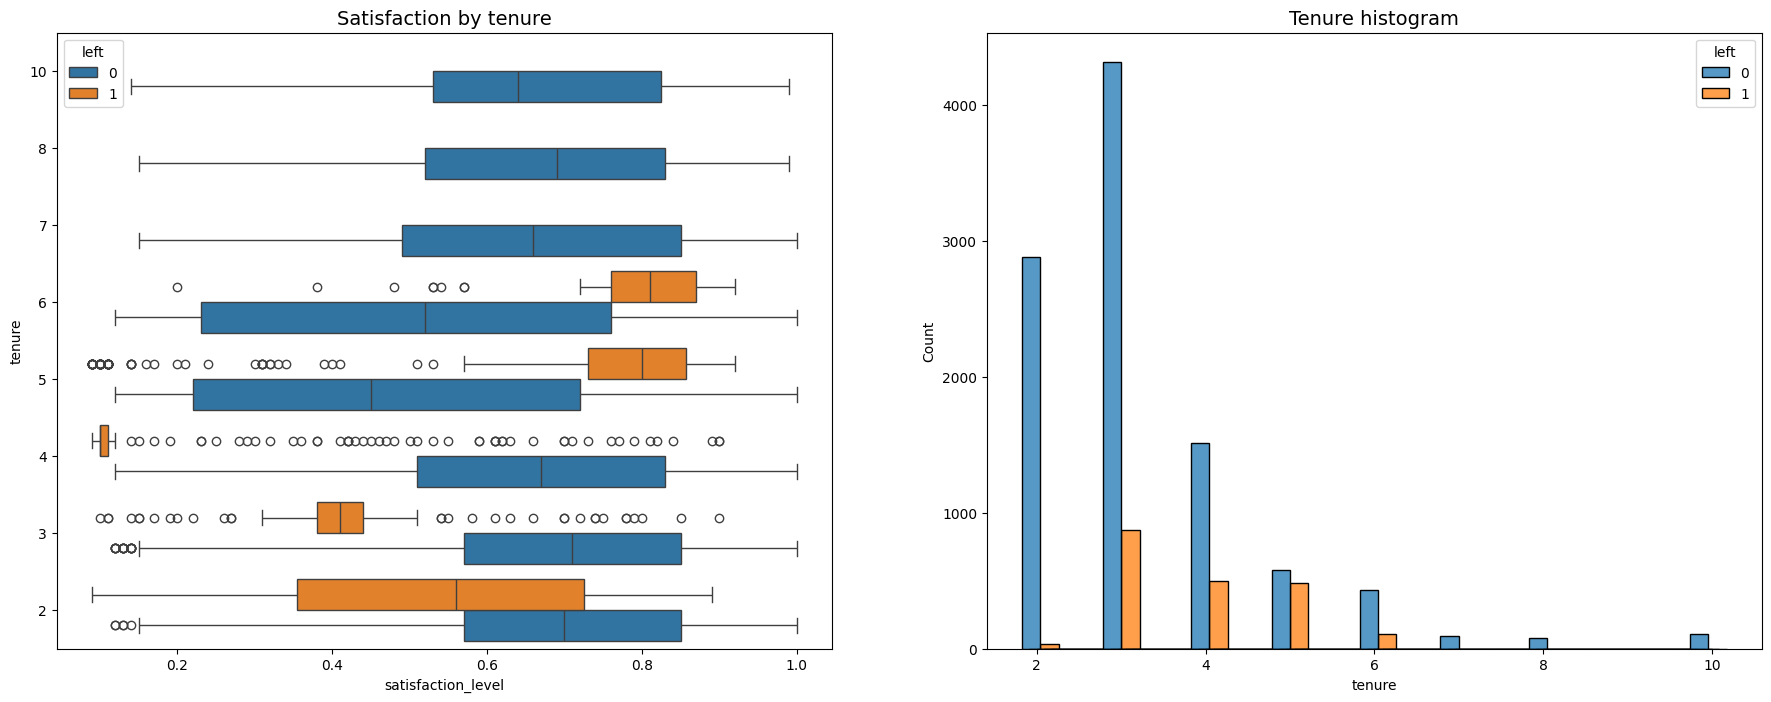

In [16]:
# Check satisfaction levels by tenure
fig, ax = plt.subplots(1, 2, figsize = (22,8))

sns.boxplot(data=df1, x='satisfaction_level', y='tenure', hue='left', orient="h", ax=ax[0])
ax[0].invert_yaxis()
ax[0].set_title('Satisfaction by tenure', fontsize='14')

# check distribution of `tenure`, comparing employees who stayed versus those who left
sns.histplot(data=df1, x='tenure', hue='left', multiple='dodge', shrink=5, ax=ax[1])
ax[1].set_title('Tenure histogram', fontsize='14')

plt.show();

We can divide employees into two categories: dissatisfied employees with shorter tenures and very satisfied employees with medium-length tenures.

4-year employees who left seem to have very low satisfaction level. The reason might be that some policies changes to company policy that might have affected people specifically for the 4-year line, if possible.

The longest-tenured employees didn't leave. Their satisfaction levels aligned with those of newer employees who stayed.
The histogram shows that there are relatively few longer-tenured employees. It's possible that they're the higher-ranking, higher-paid employees.

In [17]:
# Calculate mean and median satisfaction_level of employees who left vs. stayed
df1.groupby(['left'])['satisfaction_level'].agg([np.mean,np.median])

<ipython-input-17-0484f905615d>:2: FutureWarning: The provided callable <function mean at 0x7d5c952cbd00> is currently using SeriesGroupBy.mean. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "mean" instead.
  df1.groupby(['left'])['satisfaction_level'].agg([np.mean,np.median])
<ipython-input-17-0484f905615d>:2: FutureWarning: The provided callable <function median at 0x7d5c94d17400> is currently using SeriesGroupBy.median. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "median" instead.
  df1.groupby(['left'])['satisfaction_level'].agg([np.mean,np.median])


,mean,median
left,,
0,0.667365,0.69
1,0.440271,0.41


The mean and median scores of employees who left are lower than those of employees who stayed. However, for those employees who stayed, the mean score is slightly lower than the median score. This shows that satisfaction levels for those who stayed might be skewed to the left.

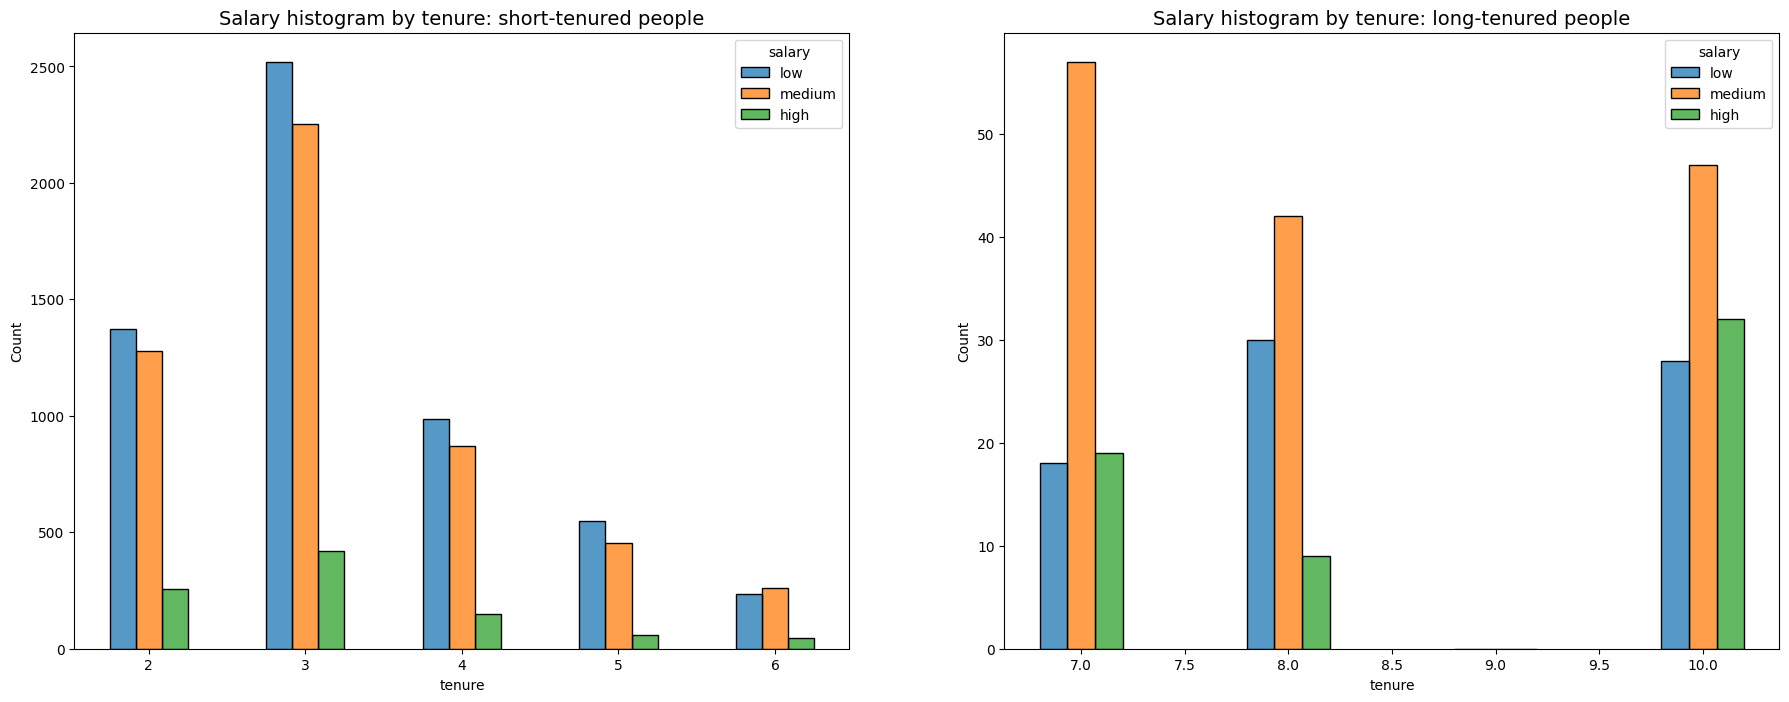

In [18]:
# Examine salary levels for different tenures.
fig, ax = plt.subplots(1, 2, figsize = (22,8))

# Define short-tenured employees
tenure_short = df1[df1['tenure'] < 7]

# Define long-tenured employees
tenure_long = df1[df1['tenure'] > 6]

# Plot short-tenured histogram
sns.histplot(data=tenure_short, x='tenure', hue='salary', discrete=1,
             hue_order=['low', 'medium', 'high'], multiple='dodge', shrink=.5, ax=ax[0])
ax[0].set_title('Salary histogram by tenure: short-tenured people', fontsize='14')

# Plot long-tenured histogram
sns.histplot(data=tenure_long, x='tenure', hue='salary', discrete=1,
             hue_order=['low', 'medium', 'high'], multiple='dodge', shrink=.4, ax=ax[1])
ax[1].set_title('Salary histogram by tenure: long-tenured people', fontsize='14');

The plots above show that higher-paid employees don't take large part of long-tenured employees.

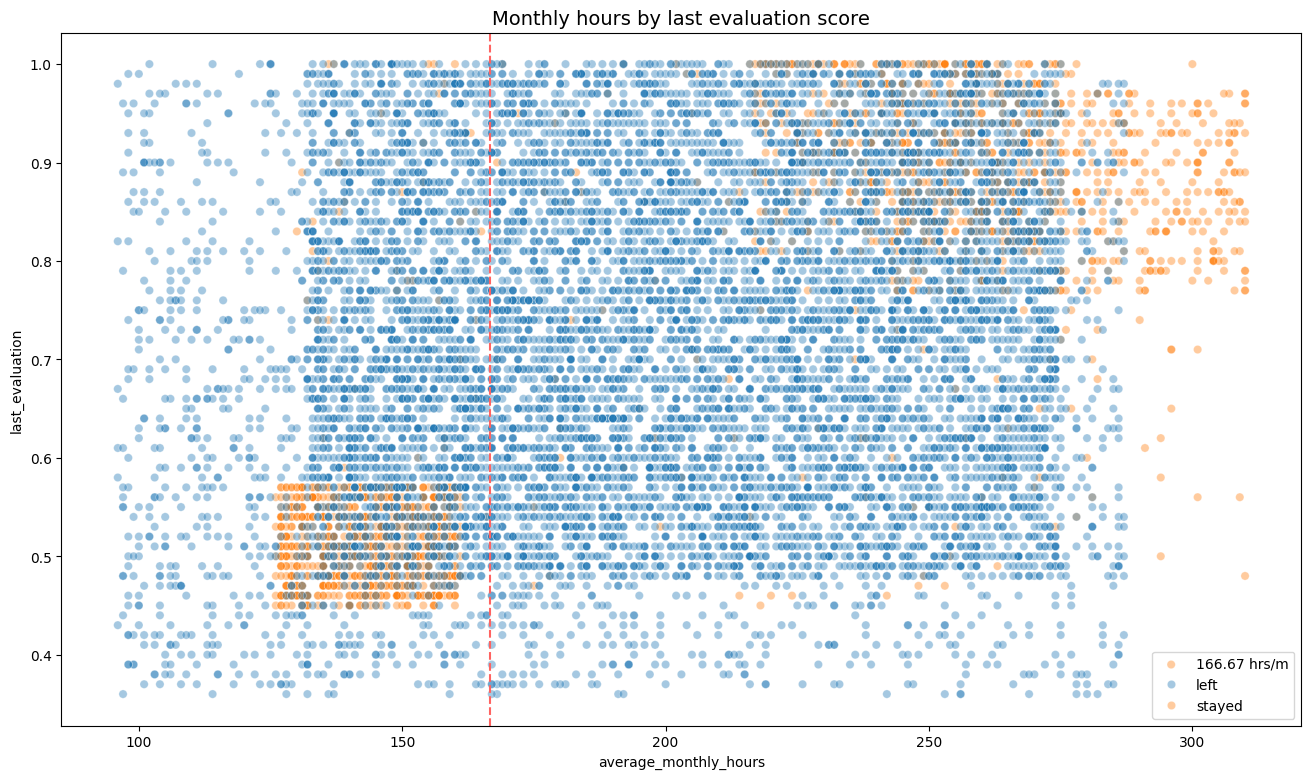

In [19]:
# Check correlation between working long hours and receiving high evaluation scores.
plt.figure(figsize=(16, 9))
sns.scatterplot(data=df1, x='average_monthly_hours', y='last_evaluation', hue='left', alpha=0.4)
plt.axvline(x=166.67, color='#ff6361', label='166.67 hrs/m', ls='--')
plt.legend(labels=['166.67 hrs/m', 'left', 'stayed'])
plt.title('Monthly hours by last evaluation score', fontsize='14');

The scatterplot shows two groups of employees who left: overworked employees who performed very well and employees who worked slightly under the nominal monthly average of 166.67 hours with lower evaluation scores.
There seems to be a correlation between hours worked and evaluation score.
There isn't a high percentage of employees in the upper left area of this plot; but working long hours doesn't guarantee a good evaluation score.
Most of the employees in this company work well over 167 hours per month.


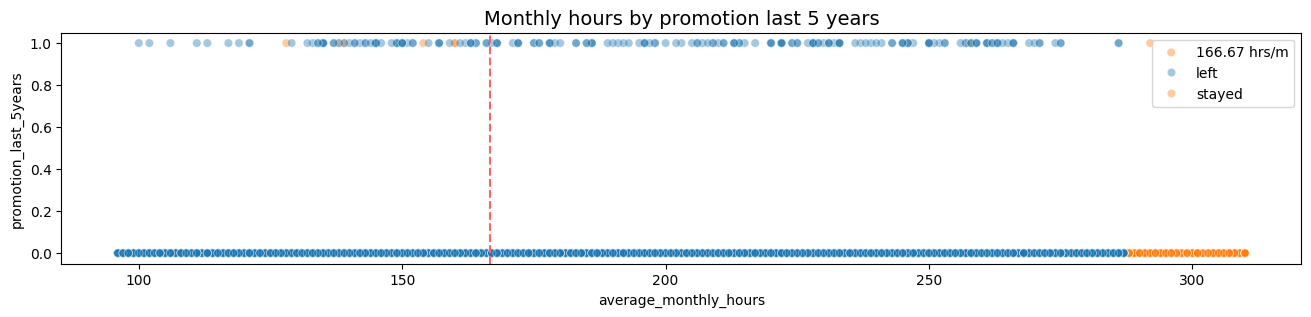

In [20]:
# Check whether employees who worked very long hours were promoted in the last five years
plt.figure(figsize=(16, 3))
sns.scatterplot(data=df1, x='average_monthly_hours', y='promotion_last_5years', hue='left', alpha=0.4)
plt.axvline(x=166.67, color='#ff6361', ls='--')
plt.legend(labels=['166.67 hrs/m', 'left', 'stayed'])
plt.title('Monthly hours by promotion last 5 years', fontsize='14');

Very few employees who were promoted in the last five years left, and
very few employees who worked the most hours were promoted.

# All of the employees who left were working the longest hours.

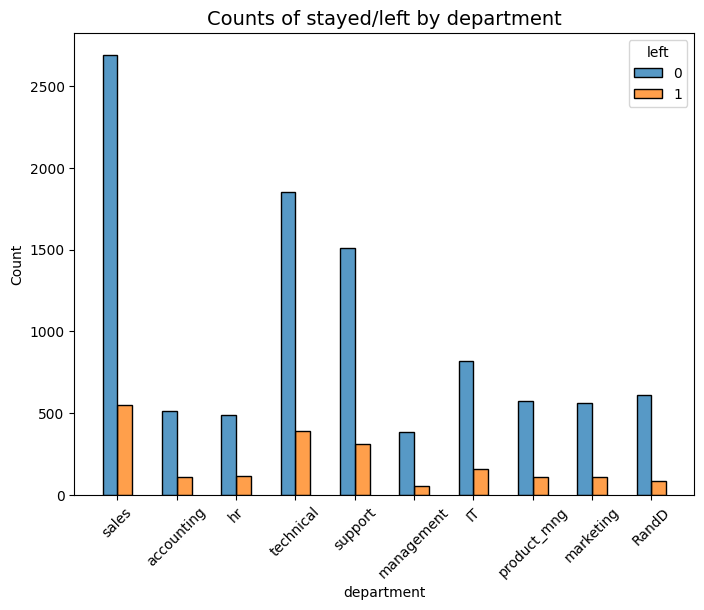

In [21]:
# Compare department distribution of employees who left vs. stay
plt.figure(figsize=(8,6))
sns.histplot(data=df1, x='department', hue='left', discrete=1,
             hue_order=[0, 1], multiple='dodge', shrink=.5)
plt.xticks(rotation=45)
plt.title('Counts of stayed/left by department', fontsize=14);

There is no any department has significantly difference in its proportion of employees who left to those who stayed.

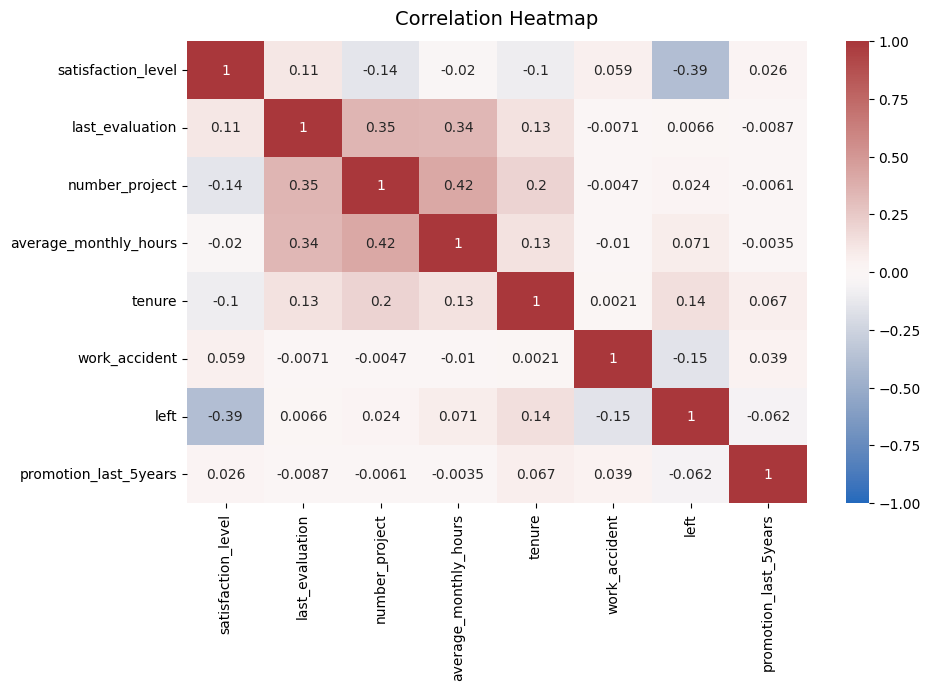

In [22]:
# Check for strong correlations between variables in the data.
plt.figure(figsize=(10,6))
heatmap = sns.heatmap(df.drop(columns=['department','salary']).corr(), vmin=-1, vmax=1, annot=True, cmap=sns.color_palette("vlag", as_cmap=True))
heatmap.set_title('Correlation Heatmap', fontdict={'fontsize':14}, pad=12);

The correlation heatmap confirms that the number of projects, monthly hours, and evaluation scores all have some positive correlation with each other, and whether an employee leaves is negatively correlated with their satisfaction level.

# Construct the model : Tree base models


In [23]:
# Convert catergorical features to numerical features
# The 'salary' is ordinal, it's better to covert it into 0-2 levels
df2 = df1.copy()
df2['salary'] = df2['salary'].map({'low':0, 'medium':1, 'high':2})

# Covert department into numerical data
df2 = pd.get_dummies(df2, dtype=int, drop_first=True)



df2.head()


,satisfaction_level,last_evaluation,number_project,average_monthly_hours,tenure,work_accident,left,promotion_last_5years,salary,department_RandD,department_accounting,department_hr,department_management,department_marketing,department_product_mng,department_sales,department_support,department_technical
0,0.38,0.53,2,157,3,0,1,0,0,0,0,0,0,0,0,1,0,0
1,0.80,0.86,5,262,6,0,1,0,1,0,0,0,0,0,0,1,0,0
2,0.11,0.88,7,272,4,0,1,0,1,0,0,0,0,0,0,1,0,0
3,0.72,0.87,5,223,5,0,1,0,0,0,0,0,0,0,0,1,0,0
4,0.37,0.52,2,159,3,0,1,0,0,0,0,0,0,0,0,1,0,0


In [24]:
# Prepare train and test data
y = df2['left']
X = df2.drop(columns=['left'])

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

In [25]:
# Build a decision tree model and Grid search for best params
dt1 = DecisionTreeClassifier(random_state=0)
# Assign a dictionary of hyperparameters to search over
cv_params = {'max_depth':[4, 6, 8, None],
             'min_samples_leaf': [2, 5, 1],
             'min_samples_split': [2, 4, 6]
             }
# Assign a dictionary of scoring metrics to capture
scoring = ['accuracy', 'precision', 'recall', 'f1', 'roc_auc']

# Instantiate GridSearch
tree1 = GridSearchCV(dt1, cv_params, scoring=scoring, cv=4, refit='roc_auc')

In general, the cost of misclassifying an employee as likely to stay when they are actually going to leave is higher than the cost of misclassifying an employee as likely to leave when they are not. This is because it is more expensive to train a new employee than to convince an existing employee to stay. In this situation, the recall score might be a better metric for evaluating the performance of models. However, since each company has different hiring and training processes, it's challenging to determine a universally suitable recall score. Therefore, the ROC AUC score might be a better metric as it balances both precision and recall.


In [26]:
# Training model
%%time

tree1.fit(X_train, y_train)

CPU times: user 4.18 s, sys: 0 ns, total: 4.18 s
Wall time: 4.28 s


GridSearchCV(cv=4, estimator=DecisionTreeClassifier(random_state=0),
             param_grid={'max_depth': [4, 6, 8, None],
                         'min_samples_leaf': [2, 5, 1],
                         'min_samples_split': [2, 4, 6]},
             refit='roc_auc',
             scoring=['accuracy', 'precision', 'recall', 'f1', 'roc_auc'])

In [27]:
# Check best parameters
tree1.best_params_

{'max_depth': 6, 'min_samples_leaf': 2, 'min_samples_split': 6}

In [28]:
# Check best AUC score on CV
tree1.best_score_

0.9710353213104661

In [29]:
# A function that will help you extract all the scores from the grid search.
def make_results(model_name:str, model_object, metric:str):
    '''
    Arguments:
        model_name (string): what you want the model to be called in the output table
        model_object: a fit GridSearchCV object
        metric (string): precision, recall, f1, accuracy, or auc

    Returns a pandas df with the F1, recall, precision, accuracy, and auc scores
    for the model with the best mean 'metric' score across all validation folds.
    '''

    # Create dictionary that maps input metric to actual metric name in GridSearchCV
    metric_dict = {'auc': 'mean_test_roc_auc',
                   'precision': 'mean_test_precision',
                   'recall': 'mean_test_recall',
                   'f1': 'mean_test_f1',
                   'accuracy': 'mean_test_accuracy'
                  }

    # Get all the results from the CV and put them in a df
    cv_results = pd.DataFrame(model_object.cv_results_)

    # Isolate the row of the df with the max(metric) score
    best_estimator_results = cv_results.iloc[cv_results[metric_dict[metric]].idxmax(), :]

    # Extract Accuracy, precision, recall, and f1 score from that row
    auc = best_estimator_results.mean_test_roc_auc
    f1 = best_estimator_results.mean_test_f1
    recall = best_estimator_results.mean_test_recall
    precision = best_estimator_results.mean_test_precision
    accuracy = best_estimator_results.mean_test_accuracy

    # Create table of results
    table = pd.DataFrame()
    table = pd.DataFrame({'model': [model_name],
                          'precision': [precision],
                          'recall': [recall],
                          'F1': [f1],
                          'accuracy': [accuracy],
                          'auc': [auc]
                        })

    return table

In [30]:
# Get all CV scores
tree1_cv_results = make_results('decision tree cv', tree1, 'auc')
tree1_cv_results

,model,precision,recall,F1,accuracy,auc
0,decision tree cv,0.962577,0.917079,0.939137,0.979983,0.971035


All of these scores from the decision tree model are strong indicators of good model performance.

Decision trees can be vulnerable to overfitting, and random forests avoid overfitting by incorporating multiple trees to make predictions. Construct a random forest model next.


In [31]:
# Construct a random forest model
rf = RandomForestClassifier(random_state=0)

# Assign a dictionary of hyperparameters to search over
cv_params = {'max_depth': [3,5, None],
             'max_features': [1.0],
             'max_samples': [0.7, 1.0],
             'min_samples_leaf': [1,2,3],
             'min_samples_split': [2,3,4],
             'n_estimators': [300, 500],
             }

# Assign a dictionary of scoring metrics to capture
scoring = ['accuracy', 'precision', 'recall', 'f1', 'roc_auc']

# Instantiate GridSearch
rf1 = GridSearchCV(rf, cv_params, scoring=scoring, cv=4, refit='roc_auc')

In [32]:
%%time
rf1.fit(X_train, y_train)

CPU times: user 25min 51s, sys: 2.49 s, total: 25min 54s
Wall time: 26min 8s


GridSearchCV(cv=4, estimator=RandomForestClassifier(random_state=0),
             param_grid={'max_depth': [3, 5, None], 'max_features': [1.0],
                         'max_samples': [0.7, 1.0],
                         'min_samples_leaf': [1, 2, 3],
                         'min_samples_split': [2, 3, 4],
                         'n_estimators': [300, 500]},
             refit='roc_auc',
             scoring=['accuracy', 'precision', 'recall', 'f1', 'roc_auc'])

In [33]:
# Define a path to the folder where you want to save the model
path = '/content/drive/MyDrive/Colab Notebooks/HR data analysis'


In [34]:
def write_pickle(path, model_object, save_as:str):
    '''
    In:
        path:         path of folder where you want to save the pickle
        model_object: a model you want to pickle
        save_as:      filename for how you want to save the model

    Out: A call to pickle the model in the folder indicated
    '''

    with open(path + save_as + '.pickle', 'wb') as to_write:
        pickle.dump(model_object, to_write)

def read_pickle(path, saved_model_name:str):
    '''
    In:
        path:             path to folder where you want to read from
        saved_model_name: filename of pickled model you want to read in

    Out:
        model: the pickled model
    '''
    with open(path + saved_model_name + '.pickle', 'rb') as to_read:
        model = pickle.load(to_read)

    return model

In [35]:
# Write rf1 model into pickle file
write_pickle(path, rf1, 'hr_rf1')

In [36]:
# read_pickle(path,'hr_rf1')

GridSearchCV(cv=4, estimator=RandomForestClassifier(random_state=0),
             param_grid={'max_depth': [3, 5, None], 'max_features': [1.0],
                         'max_samples': [0.7, 1.0],
                         'min_samples_leaf': [1, 2, 3],
                         'min_samples_split': [2, 3, 4],
                         'n_estimators': [300, 500]},
             refit='roc_auc',
             scoring=['accuracy', 'precision', 'recall', 'f1', 'roc_auc'])

In [37]:
# Check best params
rf1.best_params_

{'max_depth': 5,
 'max_features': 1.0,
 'max_samples': 0.7,
 'min_samples_leaf': 2,
 'min_samples_split': 2,
 'n_estimators': 500}

In [38]:
# Get all CV scores
rf1_cv_results = make_results('random forest cv', rf1, 'auc')
print(tree1_cv_results)
print(rf1_cv_results)

              model  precision    recall        F1  accuracy       auc
0  decision tree cv   0.962577  0.917079  0.939137  0.979983  0.971035
              model  precision    recall        F1  accuracy       auc
0  random forest cv   0.951614  0.912129  0.931377  0.977377  0.980926


In [39]:
def get_scores(model_name:str, model, X_test_data, y_test_data):
    '''
    Generate a table of test scores.

    In:
        model_name (string):  How you want your model to be named in the output table
        model:                A fit GridSearchCV object
        X_test_data:          numpy array of X_test data
        y_test_data:          numpy array of y_test data

    Out: pandas df of precision, recall, f1, accuracy, and AUC scores for your model
    '''

    preds = model.best_estimator_.predict(X_test_data)

    auc = roc_auc_score(y_test_data, preds)
    accuracy = accuracy_score(y_test_data, preds)
    precision = precision_score(y_test_data, preds)
    recall = recall_score(y_test_data, preds)
    f1 = f1_score(y_test_data, preds)

    table = pd.DataFrame({'model': [model_name],
                          'precision': [precision],
                          'recall': [recall],
                          'f1': [f1],
                          'accuracy': [accuracy],
                          'AUC': [auc]
                         })

    return table

In [40]:
# Get predictions on test data
rf1_test_scores = get_scores('random forest1 test', rf1, X_test, y_test)
rf1_test_scores

,model,precision,recall,f1,accuracy,AUC
0,random forest1 test,0.958791,0.930667,0.94452,0.98291,0.961628


The test scores are very similar to the validation scores, which is good. This appears to be a strong model. Since this test set was only used for this model, you can be more confident that your model's performance on this data is representative of how it will perform on new, unseeen data.

# Feature Engineering
The high evaluation scores shows there is a chance that there is some data leakage occurring.

In this case, it's likely that the company won't have satisfaction levels reported for all of its employees. It's also possible that the average_monthly_hours column is a source of some data leakage. If employees have already decided upon quitting, or have already been identified by management as people to be fired, they may be working fewer hours.

The previous decision tree and random forest models included all variables as features. This second model building will incorporate feature engineering to build improved models.

Dropping satisfaction_level and creating a new feature that captures whether an employee is overworked.

In [41]:
# Drop `satisfaction_level` and save resulting dataframe in new variable
df3 = df2.drop('satisfaction_level', axis=1)

# Create `overworked` column. For now, it's identical to average monthly hours.
df3['overworked'] = df3['average_monthly_hours']

# Inspect max and min average monthly hours values
print('Max hours:', df3['overworked'].max())
print('Min hours:', df3['overworked'].min())

Max hours: 310
Min hours: 96


166.67hrs is approximately the average number of monthly hours for someone who works 50 weeks per year, 5 days per week, 8 hours per day.

Define being overworked as working more than 175 hours per month on average.

In [42]:
# Define `overworked` as working > 175 hrs/week
df3['overworked'] = (df3['overworked'] > 175).astype(int)

# Display first few rows of new column
df3['overworked'].head()

,overworked
0,0
1,1
2,1
3,1
4,0


In [43]:
df3.drop('average_monthly_hours', axis=1)

# Prepare train and test data after feature engineering
y = df3['left']
X = df3.drop(columns=['left'])

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

In [44]:
# Build a decision tree model
tree = DecisionTreeClassifier(random_state=0)

CV_params = {'max_depth':[4, 6, 8, None],
             'min_samples_leaf': [2, 5, 1],
             'min_samples_split': [2, 4, 6]
             }

# Assign a dictionary of scoring metrics to capture
scoring = ['accuracy', 'precision', 'recall', 'f1', 'roc_auc']

tree2 = GridSearchCV(tree, CV_params, scoring=scoring, cv=4, refit='roc_auc')

In [45]:
%%time
tree2.fit(X_train, y_train)

CPU times: user 3.84 s, sys: 10 ms, total: 3.85 s
Wall time: 3.86 s


GridSearchCV(cv=4, estimator=DecisionTreeClassifier(random_state=0),
             param_grid={'max_depth': [4, 6, 8, None],
                         'min_samples_leaf': [2, 5, 1],
                         'min_samples_split': [2, 4, 6]},
             refit='roc_auc',
             scoring=['accuracy', 'precision', 'recall', 'f1', 'roc_auc'])

In [46]:
# Check best params
print(tree2.best_params_)

# Check best AUC score on CV
print(tree2.best_score_)

# Get all CV scores
tree2_cv_results = make_results('decision tree2 cv', tree2, 'auc')
print(tree1_cv_results)
print(tree2_cv_results)

{'max_depth': 6, 'min_samples_leaf': 1, 'min_samples_split': 6}
0.9684980063954238
              model  precision    recall        F1  accuracy       auc
0  decision tree cv   0.962577  0.917079  0.939137  0.979983  0.971035
               model  precision    recall        F1  accuracy       auc
0  decision tree2 cv   0.864419  0.919554  0.890879  0.961947  0.968498


In [47]:
# Create a randomforest tree after feature engineering
rf = RandomForestClassifier(random_state=0)

# Assign a dictionary of hyperparameters to search over
cv_params = {'max_depth': [3,5, None],
             'max_features': [1.0],
             'max_samples': [0.7, 1.0],
             'min_samples_leaf': [1,2,3],
             'min_samples_split': [2,3,4],
             'n_estimators': [300, 500],
             }

# Assign a dictionary of scoring metrics to capture
scoring = ['accuracy', 'precision', 'recall', 'f1', 'roc_auc']

# Instantiate GridSearch
rf2 = GridSearchCV(rf, cv_params, scoring=scoring, cv=4, refit='roc_auc')

In [48]:
%%time
rf2.fit(X_train, y_train)

CPU times: user 23min 1s, sys: 2.45 s, total: 23min 4s
Wall time: 23min 12s


GridSearchCV(cv=4, estimator=RandomForestClassifier(random_state=0),
             param_grid={'max_depth': [3, 5, None], 'max_features': [1.0],
                         'max_samples': [0.7, 1.0],
                         'min_samples_leaf': [1, 2, 3],
                         'min_samples_split': [2, 3, 4],
                         'n_estimators': [300, 500]},
             refit='roc_auc',
             scoring=['accuracy', 'precision', 'recall', 'f1', 'roc_auc'])

In [49]:
# Write pickle
write_pickle(path, rf2, 'hr_rf2')

In [50]:
# Read in pickle
# rf2 = read_pickle(path, 'hr_rf2')

In [51]:
# Check best params
print(rf2.best_params_)

# Check best AUC score on CV
print(rf2.best_score_)

# Get all CV scores
rf2_cv_results = make_results('random forest2 cv', rf2, 'auc')
print(tree2_cv_results)
print(rf2_cv_results)

{'max_depth': 5, 'max_features': 1.0, 'max_samples': 1.0, 'min_samples_leaf': 3, 'min_samples_split': 2, 'n_estimators': 300}
0.9743292377131394
               model  precision    recall        F1  accuracy       auc
0  decision tree2 cv   0.864419  0.919554  0.890879  0.961947  0.968498
               model  precision    recall        F1  accuracy       auc
0  random forest2 cv   0.902124  0.908416  0.904973  0.967786  0.974329


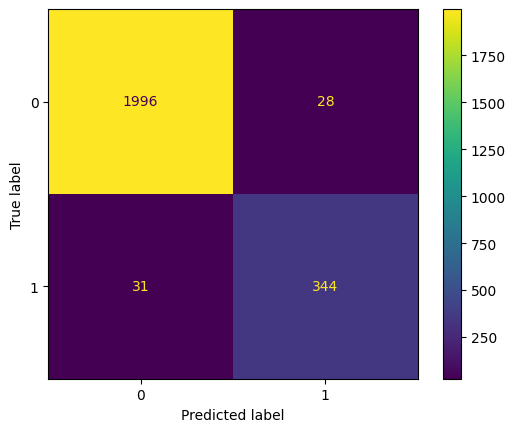

In [52]:
# Generate array of values for confusion matrix
y_pred = rf2.best_estimator_.predict(X_test)
cm = confusion_matrix(y_test, y_pred, labels=rf2.classes_)

# Plot confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                             display_labels=rf2.classes_)
disp.plot(values_format='');

The model predicts more false positives than false negatives, which means that some employees may be identified as at risk of quitting or getting fired, when that's actually not the case. But this is still a strong model.

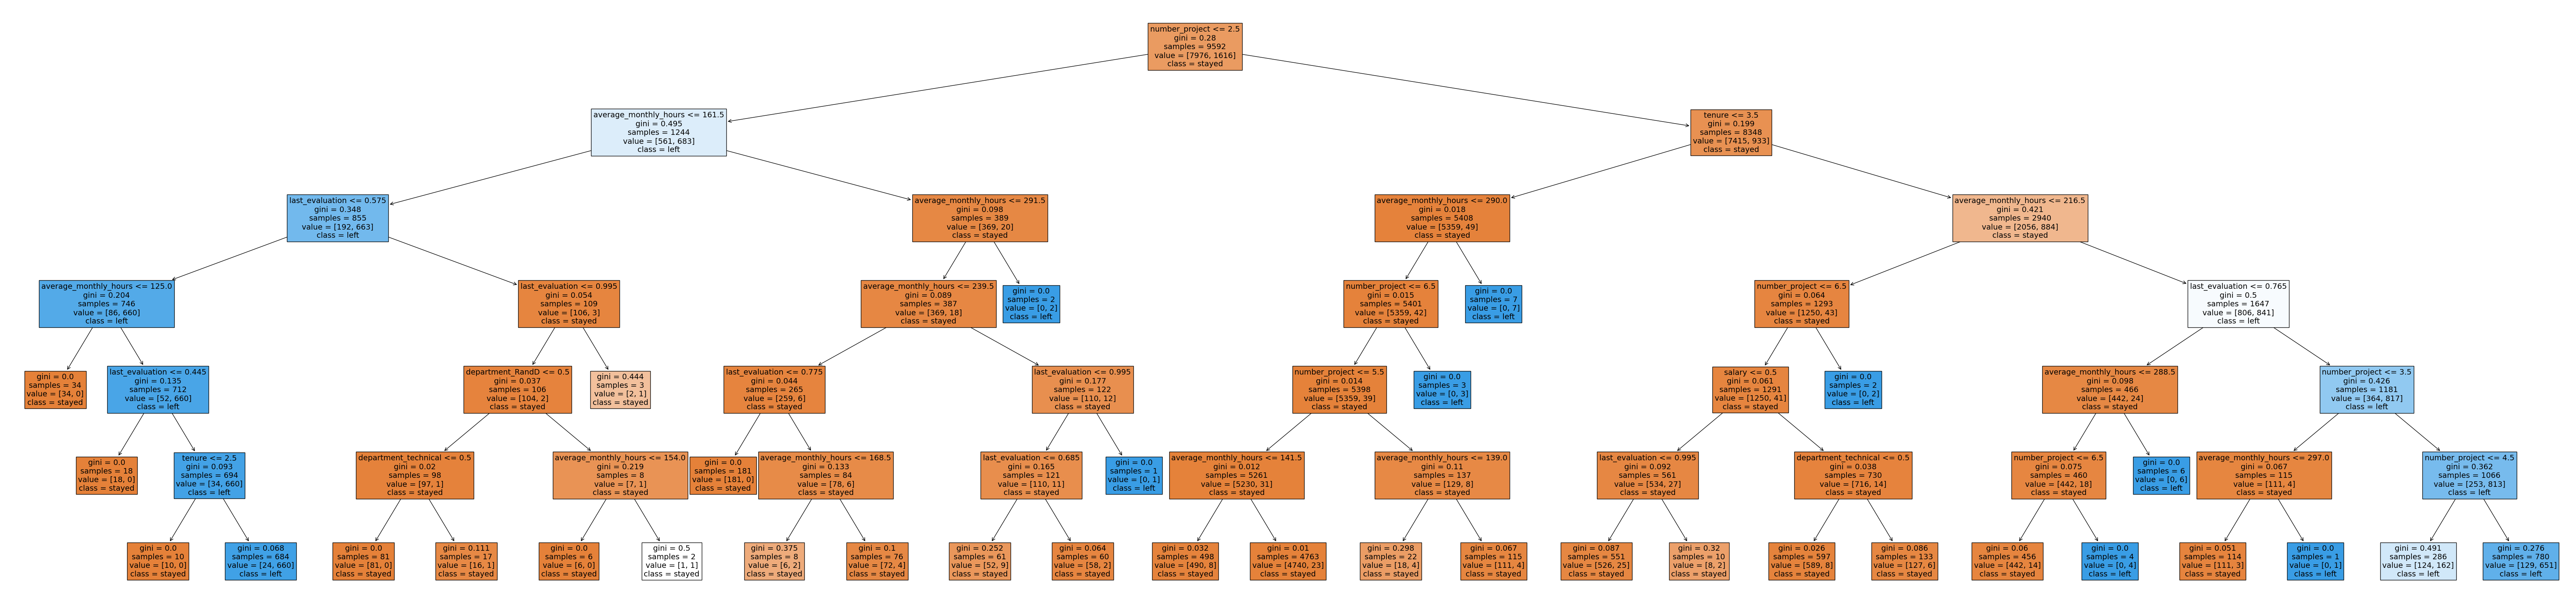

In [53]:
# Plot the tree to  inspect the splits of the decision tree model
plt.figure(figsize=(85,20))
plot_tree(tree2.best_estimator_, max_depth=6, fontsize=14, feature_names=X.columns,
          class_names={0:'stayed', 1:'left'}, filled=True);
plt.show()

                       gini_importance
average_monthly_hours         0.338878
number_project                0.277056
last_evaluation               0.217755
tenure                        0.165806
salary                        0.000258
department_technical          0.000153
department_RandD              0.000094


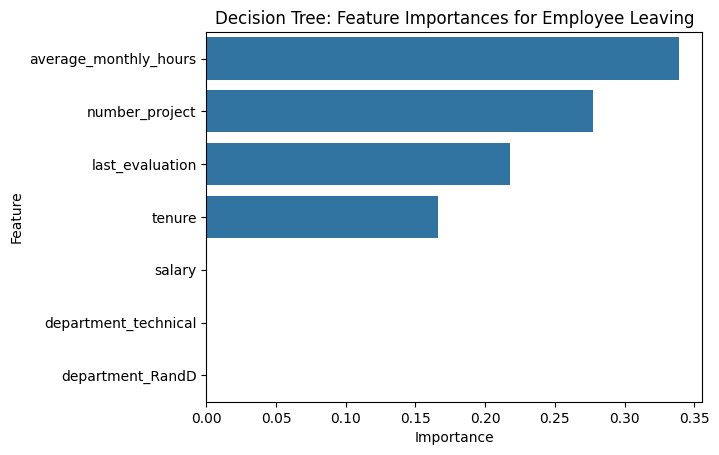

In [54]:
#  Inspeact the most important feature of the decision tree model
tree2_importances = pd.DataFrame(tree2.best_estimator_.feature_importances_,
                                 columns=['gini_importance'],
                                 index=X.columns
                                )
tree2_importances = tree2_importances.sort_values(by='gini_importance', ascending=False)

# Only extract the features with importances > 0
tree2_importances = tree2_importances[tree2_importances['gini_importance'] != 0]
print(tree2_importances)


sns.barplot(data=tree2_importances, x="gini_importance", y=tree2_importances.index, orient='h')
plt.title("Decision Tree: Feature Importances for Employee Leaving", fontsize=12)
plt.ylabel("Feature")
plt.xlabel("Importance")
plt.show()

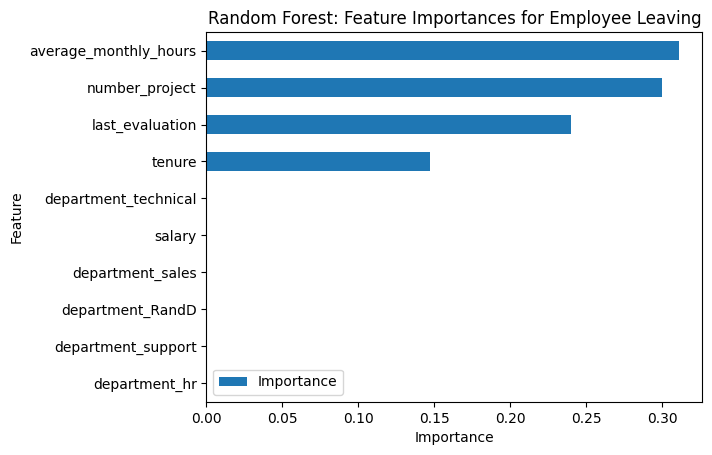

In [55]:
# Inspect the most important feature in the RandomForest model
# Get feature importances
feat_impt = rf2.best_estimator_.feature_importances_

# Get indices of top 10 features
ind = np.argpartition(rf2.best_estimator_.feature_importances_, -10)[-10:]

# Get column labels of top 10 features
feat = X.columns[ind]

# Filter `feat_impt` to consist of top 10 feature importances
feat_impt = feat_impt[ind]

y_df = pd.DataFrame({"Feature":feat,"Importance":feat_impt})
y_sort_df = y_df.sort_values("Importance")
fig = plt.figure()
ax1 = fig.add_subplot(111)

y_sort_df.plot(kind='barh',ax=ax1,x="Feature",y="Importance")

ax1.set_title("Random Forest: Feature Importances for Employee Leaving", fontsize=12)
ax1.set_ylabel("Feature")
ax1.set_xlabel("Importance")


plt.show()

To retain employees:

1. Limit the number of projects that employees can work on.

2. Consider promoting employees who have been with the company for atleast four years, or conduct further investigation about why four-year tenured employees are so dissatisfied.

3. Either reward employees for working longer hours, or don't require them to do so.

4. If employees aren't familiar with the company's overtime pay policies, inform them about this. If the expectations around workload and time off aren't explicit, make them clear.

5. High evaluation scores should not be reserved for employees who work 200+ hours per month. Consider a proportionate scale for rewarding employees who contribute more/put in more effort.

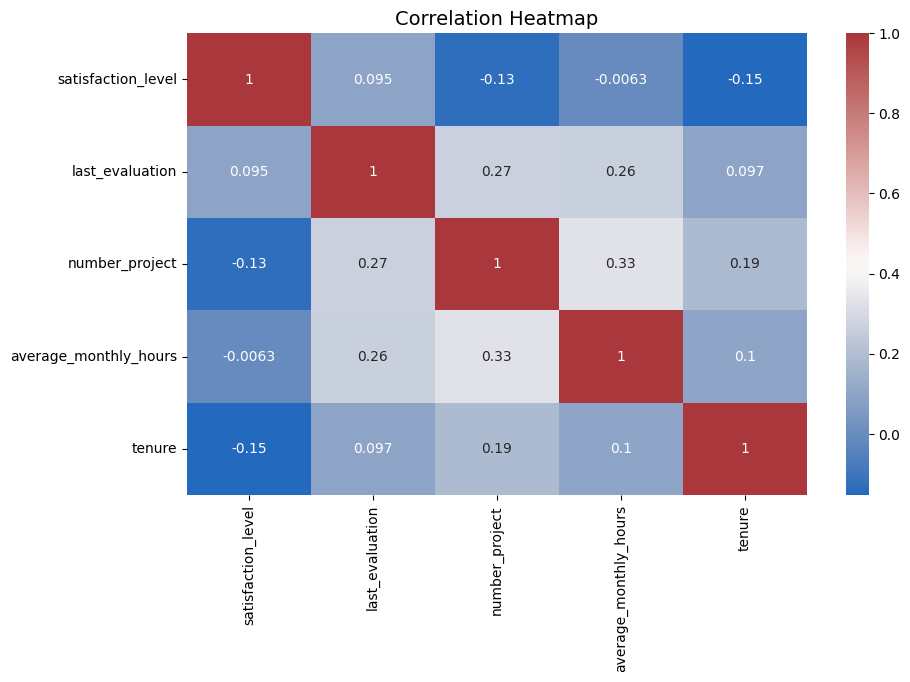

In [56]:
# Create a heatmap to visualize ['satisfaction_level', 'last_evaluation',
#  'number_project', 'average_monthly_hours', 'tenure'] how correlated they are.
plt.figure(figsize=(10,6))
sns.heatmap(data=df2[['satisfaction_level', 'last_evaluation', 'number_project', 'average_monthly_hours', 'tenure']].corr(), cmap=sns.color_palette("vlag", as_cmap=True), annot=True)
plt.title('Correlation Heatmap', fontsize=14);
plt.show()